In [1]:
import os


if(os.path.exists('x86_64')==False):
    %cd ../components/mechanisms/
    os.system('nrnivmodl modfiles') # compile modfiles. Return 0 for success, 1 for failure.
    %cd ../../Single_Cell_Tuning/
    %ls

%ls


/home/kac2cf/Homogenous_Models/V1-Homogenous/Model/components/mechanisms
/home/kac2cf/Homogenous_Models/V1-Homogenous/Model/components/mechanisms
Mod files: "modfiles/modfiles/AMPA_NMDA_STP.mod" "modfiles/modfiles/cadad.mod" "modfiles/modfiles/cal2.mod" "modfiles/modfiles/can_mig.mod" "modfiles/modfiles/exp2syn_stp.mod" "modfiles/modfiles/gap.mod" "modfiles/modfiles/Gfluct.mod" "modfiles/modfiles/h_kole.mod" "modfiles/modfiles/imCA3.mod" "modfiles/modfiles/kap_BS.mod" "modfiles/modfiles/kBK.mod" "modfiles/modfiles/kdmc_BS.mod" "modfiles/modfiles/kdr_BS.mod" "modfiles/modfiles/kdrCA3.mod" "modfiles/modfiles/kdrinter.mod" "modfiles/modfiles/leak.mod" "modfiles/modfiles/nainter.mod" "modfiles/modfiles/napCA3.mod" "modfiles/modfiles/natCA3.mod" "modfiles/modfiles/nax_BS.mod" "modfiles/modfiles/vecevent.mod"



/home/kac2cf/miniconda3/envs/neural-modeling/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special
/home/kac2cf/Homogenous_Models/V1-Homogenous/Model/Single_Cell_Tuning
single_cell_tuning.ipynb
single_cell_tuning.ipynb


#### Init Profiler

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from neuron import h
from bmtool.singlecell import Profiler, Passive, CurrentClamp, FI, ZAP
from scipy.stats import linregress

%ls
template_dir = os.path.join('..','components','templates')
mechanism_dir = os.path.join('..','components','mechanisms')

profiler = Profiler(template_dir=template_dir, mechanism_dir=mechanism_dir, dt = 0.05)

def run_and_plot(sim, title, xlabel, ylabel, plot=True, plot_injection_only=False,print_slope=False):
    X, Y = sim.execute()
    X = np.array(X)
    Y = np.array(Y)
    if plot:
        plt.figure()
        if plot_injection_only:
            t_idx = (X >= sim.inj_delay) & (X <= sim.inj_delay + sim.inj_dur)
            plt.plot(X[t_idx], Y[t_idx])
        else:
            plt.plot(X, Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if print_slope:
            slope, intercept, _, _, _ = linregress(X, Y)
            print("Slope of the fitted line:", slope)
    return X, Y

single_cell_tuning.ipynb


Mechanisms already loaded from path: ../components/mechanisms.  Aborting.


#### Profiler Settings

In [5]:
noise = False
post_init_function = 'insert_mechs(0)' if noise else None

# CP cell settings
basic_settings = {
    'Passive': {
        'celsius': 26.,
        'kwargs': {
            'inj_amp': -100.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 2500.,
            'method': 'exp2'
        }
    },
    'CurrentClamp': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 350.,
            'inj_delay': 1500.,
            'inj_dur': 1000.,
            'tstop': 3000.,
            'threshold': 0.
        }
    },
    'ZAP': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'inj_amp': 100.,
            'inj_delay': 1000.,
            'inj_dur': 15000.,
            'tstop': 15500.,
            'fstart': 0.,
            'fend': 15.,
            'chirp_type': 'linear'
        }
    },
    'FI': {
        'celsius': 34.,
        'kwargs': {
            'post_init_function': post_init_function,
            'i_start': 0.,
            'i_stop': 1000.,
            'i_increment': 50.,
            'tstart': 1500.
        }
    }
}
Cell_settings = {cell: deepcopy(basic_settings) for cell in ['CP_Cell', 'CS_Cell', 'FSI_Cell', 'LTS_Cell']}

# CS cell settings
settings = Cell_settings['CS_Cell']
settings['CurrentClamp']['kwargs']['inj_amp'] = 300.

# FSI cell settings
settings = Cell_settings['FSI_Cell']
settings['Passive']['celsius'] = 30.
settings['Passive']['kwargs'] = {'inj_amp': -100., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'method': 'exp2'}
settings['CurrentClamp']['celsius'] = 21.
settings['CurrentClamp']['kwargs'] = {'inj_amp': 200., 'inj_delay': 500., 'inj_dur': 500., 'tstop': 1100., 'threshold': 0.}
settings['ZAP']['celsius'] = 30.
settings['ZAP']['kwargs']['inj_amp'] = 10.
settings['FI']['celsius'] = 30.
settings['FI']['kwargs']['tstart'] = 500.
# settings['Passive'] = None
# settings['ZAP'] = None
# settings['FI'] = None

# LTS cell settings
settings = Cell_settings['LTS_Cell'] = deepcopy(Cell_settings['FSI_Cell'])
settings['CurrentClamp']['kwargs']['inj_amp'] = 50. 

#### Select Cell

In [6]:
Cell = 'CP_Cell' # CP_Cell CS_Cell FSI_Cell LTS_Cell
settings = Cell_settings[Cell]

#### Passive Properties

In [7]:
proc = settings['Passive']
if proc is not None:
    h.celsius = proc['celsius']
    sim = Passive(Cell, **proc['kwargs'])
    title = 'Passive Cell Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[0].soma[0](0.5)
Recording: CP_Cell[0].soma[0](0.5)._ref_v


Running simulation for passive properties...

V Rest: -72.35 (mV)
Resistance: 143.03 (MOhms)
Membrane time constant: 16.76 (ms)

V_rest Calculation: Voltage taken at time 1500.0 (ms) is
-72.35 (mV)

R_in Calculation: dV/dI = (v_final-v_rest)/(i_final-i_start)
(-86.65 - (-72.35)) / (-0.1 - 0)
14.30 (mV) / 0.1 (nA) = 143.03 (MOhms)

Tau Calculation: Fit a double exponential curve to the membrane potential response
f(t) = a0 + a1*exp(-t/tau1) + a2*exp(-t/tau2)
Constained by initial value: f(0) = a0 + a1 + a2 = v_rest
Fit parameters: (a0, a1, a2, tau1, tau2) = (-86.60, -6035.84, 6050.08, 16.76, 16.70)
Membrane time constant is determined from the slowest exponential term: 16.76 (ms)

Sag potential: v_sag = v_peak - v_final = -5.02 (mV)
Normalized sag potential: v_sag / (v_peak - v_rest) = 0.260



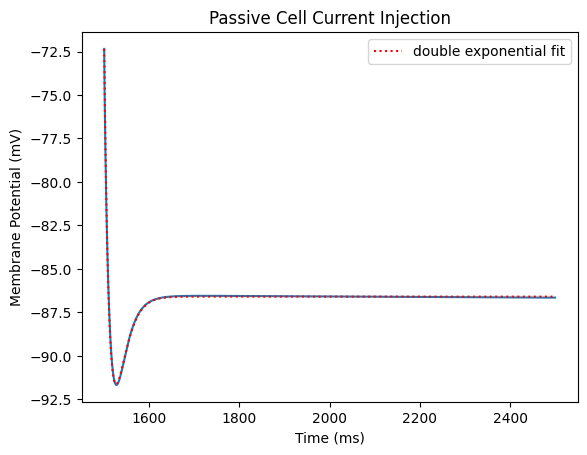

In [8]:
if proc is not None:
    if sim.method == 'exp2':
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
        plt.gca().plot(*sim.double_exponential_fit(), 'r:', label='double exponential fit')
        plt.legend()
    else:
        X, Y = run_and_plot(sim, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Current Injection

In [9]:
proc = settings['CurrentClamp']
if proc is not None:
    h.celsius = proc['celsius']
    sim2 = CurrentClamp(Cell, **proc['kwargs'])
    title = 'Current Injection'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[1].soma[0](0.5)
Recording: CP_Cell[1].soma[0](0.5)._ref_v


Current clamp simulation running...

Number of spikes: 33



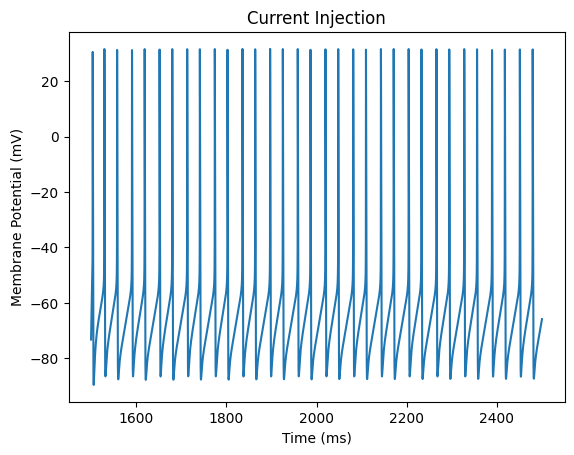

In [10]:
if proc is not None:
    X, Y = run_and_plot(sim2, title, xlabel, ylabel, plot_injection_only=True)
    plt.show()

#### Impedance Amplitude Profile (ZAP)

In [11]:
proc = settings['ZAP']
if proc is not None:
    h.celsius = proc['celsius']
    sim3 = ZAP(Cell, **proc['kwargs'])
    title = 'ZAP Response'
    xlabel = 'Time (ms)'
    ylabel = 'Membrane Potential (mV)'

Injection location: CP_Cell[2].soma[0](0.5)
Recording: CP_Cell[2].soma[0](0.5)._ref_v


In [12]:
if proc is not None:
    X, Y = run_and_plot(sim3, title, xlabel, ylabel, plot_injection_only=True)

    plt.figure()
    plt.plot(X, sim3.zap_vec)
    plt.title('ZAP Current')
    plt.xlabel('Time (ms)')
    plt.ylabel('Current Injection (nA)')

    plt.figure()
    plt.plot(*sim3.get_impedance(smooth=9))
    plt.title('Impedance Amplitude Profile')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Impedance (MOhms)')
    plt.show()

#### F-I Curve

In [ ]:
proc = settings['FI']
if proc is not None:
    h.celsius = proc['celsius']
    sim4 = FI(Cell, **proc['kwargs'])
    title = 'FI Curve'
    xlabel = 'Injection (nA)'
    ylabel = '# Spikes'

Injection location: CP_Cell[22].soma[0](0.5)
Recording: CP_Cell[22].soma[0](0.5)._ref_v


Running simulations for FI curve...

Results
Injection (nA): 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95
Number of spikes: 0, 0, 8, 15, 19, 24, 29, 33, 37, 42, 47, 52, 56, 61, 65, 71, 76, 81, 85, 90

Slope of the fitted line: 95.8345864661654


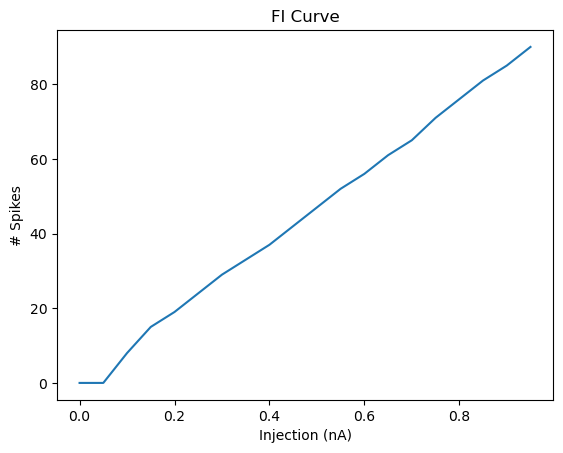

In [ ]:
if proc is not None:
    X, Y = run_and_plot(sim4, title, xlabel, ylabel,print_slope=True)
    plt.show()

#### Cell Stucture

In [ ]:
# %matplotlib ipympl
# import numpy as np
# import matplotlib.pyplot as plt
# from neuron import h

# h.load_file("stdrun.hoc")
# h.load_file('templates/templates.hoc')

# def plot_morphology(cell):
#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     for sec in cell.all:
#         x = [h.x3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         y = [h.y3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         z = [h.z3d(i, sec=sec) for i in range(int(h.n3d(sec=sec)))]
#         ax.plot(x, y, z, color='k')

#     ax.set_xlabel('X')
#     ax.set_ylabel('Y')
#     ax.set_zlabel('Z')
#     plt.show()

# cell = h.CP_Cell()

# plot_morphology(cell)
